In [1]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('SOCSEC-SURVYWIDCH.csv', index_col=['Date'], parse_dates=['Date'], dayfirst=True)
df = df[::-1]
df.rename(columns={'Total Number':'Total'}, inplace=True)

## Информация об исходных данных

**Social Security Beneficiary Data - Young Widow(er) with Child in Care** - Number of recipients and average monthly amount.

In [3]:
df.head(2)

,Total,Total Avg amount,Male Number,Male Avg Amount,Female Number,Female Avg Amount
Date,,,,,,
2000-03-31,195275.0,558.85,8870.0,465.62,186405.0,563.29
2000-04-30,197207.0,560.33,9054.0,467.49,188153.0,564.80


In [4]:
print ('Кол-во отсчетов:', df.shape[0])

Кол-во отсчетов: 201


## Анализ и преобразование ряда

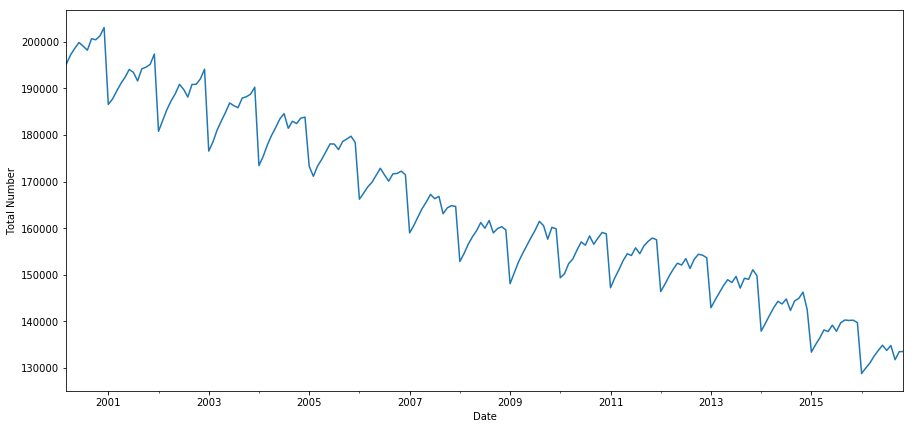

In [5]:
plt.figure(figsize(15,7))
df.Total.plot()
plt.ylabel('Total Number')
pylab.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


Критерий Дики-Фуллера: p=0.977297


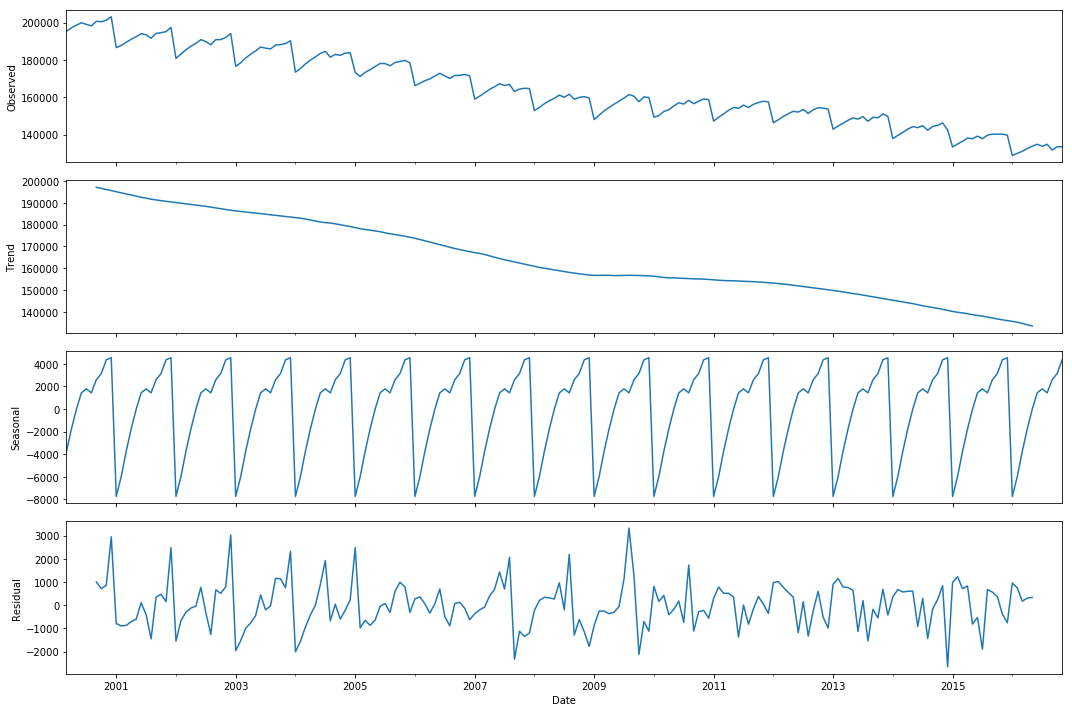

In [6]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.Total).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Total)[1])

Нестационарность ряда очевидна сразу, так как есть сильная сезонность и **четко проследивающийся тренд**. Это подтверждается критерием Дики-Фуллера, который не отвергает гипотезу о нестационарности ряда. 

Дисперсия выглядит стабильной, по этому преобразование Бокса - Кокса применять не будем.

### Сезонное дифференциирование

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


Критерий Дики-Фуллера: p=0.221195


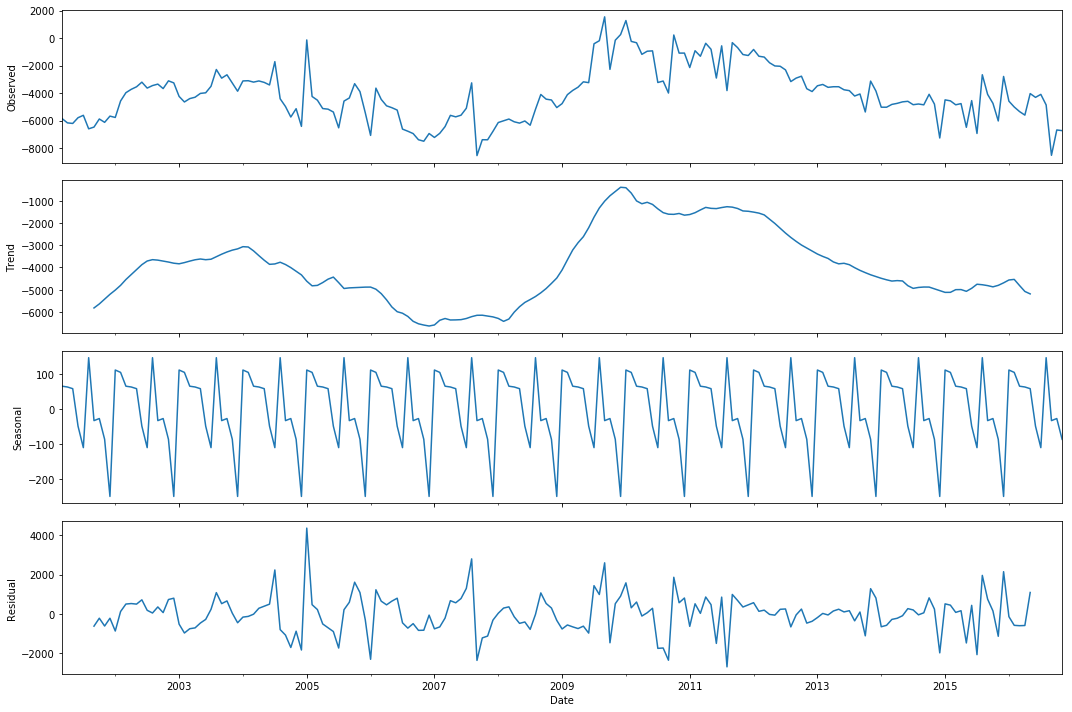

In [7]:
df['Total_diff'] = df.Total - df.Total.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.Total_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Total_diff[12:])[1])

Сразу совсем избавиться от сезонности и тренда не удалось, так они были слишком явно выражены.

Критерий Дики-Фуллера стал намного ближе к отвержению нестационарности, однако этих преобразований пока недостаточно. Добавим еще обычное дифференциирование.

### Дифференциирование ряда

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


Критерий Дики-Фуллера: p=0.000147


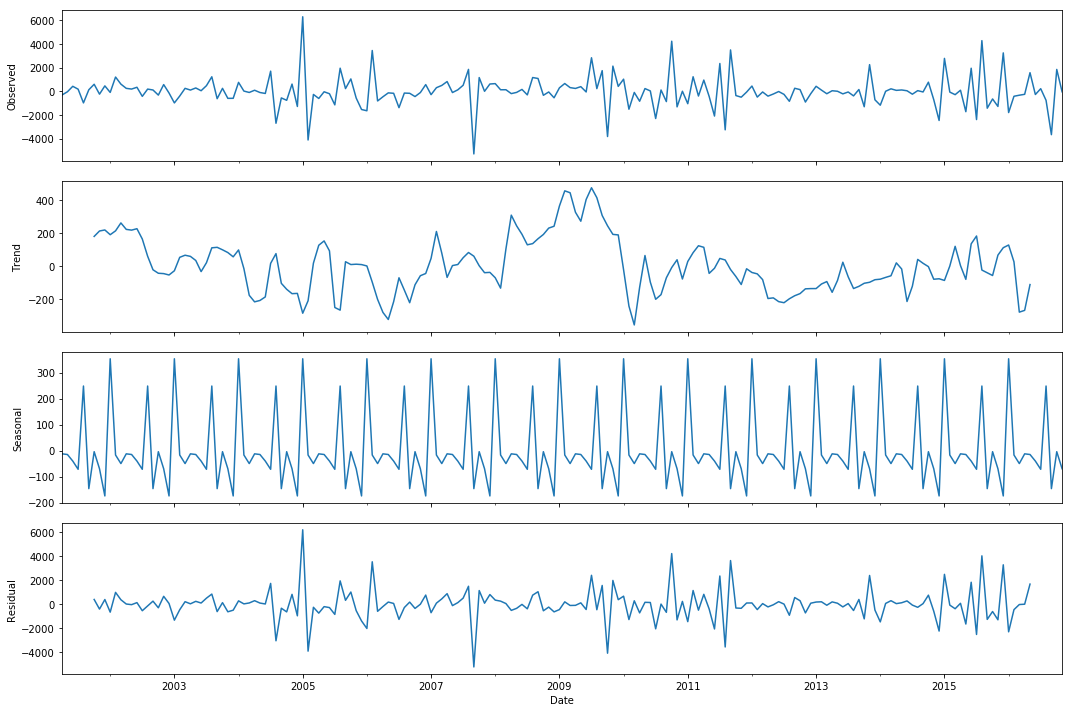

In [8]:
df['Total_diff2'] = df.Total_diff - df.Total_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.Total_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Total_diff2[13:])[1])

На данном этапе мы полнотью избавились от сезонности и тренда. Что позволяет назвать наш ряд стационарным.

**Критерий Дики-Фуллера < 0.01, значит гипотеза нестационарности ряда отвергается.**

## Подбор модели для прогнозирования

### ACF и PACF

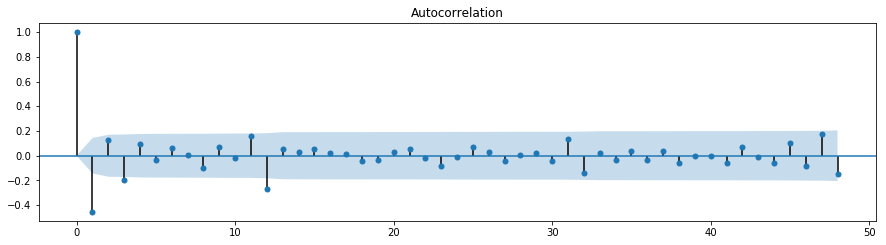

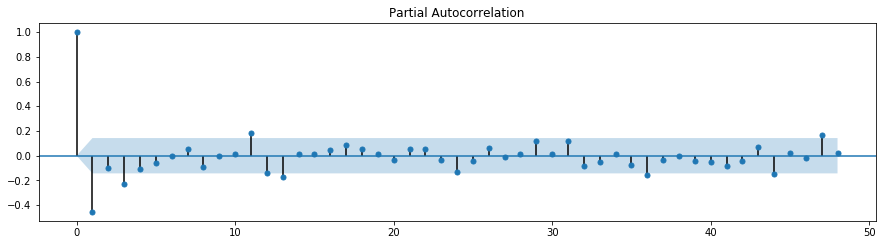

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.Total_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.Total_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Выбор приближенных значений параметров для модели прогнозирования ARIMA:

    D - сколько раз применялось сезонное дифференцирование (1)
    d - сколько раз применялось простое дифференцирование (1)


Из графика ACF:
    
    Q - номер последнего сезонного лага, при котором автокорреляция значима (1)

    q - номер последнего несезонного лага, при котором автокорреляция значима (4)

Из графика PACF:

    P - номер последнего сезонного лага, при котором частичная автокорреляция значима (1)

    p - номер последнего несезонного лага, при котором частичная автокорреляция значима (4)


In [10]:
D=1
d=1

ps = range(0, 5)
qs = range(0, 5)

Ps = range(0, 2)
Qs = range(0, 2)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

### Подбор набора параметров по критерию AIC

In [13]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.Total, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

AttributeError: module 'statsmodels.tsa.stattools' has no attribute 'SARIMAX'

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

**Лучшая модель:**

In [ ]:
print(best_model.summary())

### Остатки

In [ ]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки в хорошей модели должны удовлетворять следующим свойствам:

- **Стационарны** (подтверждается критерием Дики-Фуллера)

- **Несмещены** (подтверждается критерием Дики-Стьюдента)

- **Неавтокоррелируемы** (видно из коррелограммы)

Остатки получившейся модели подходят под эти требования.

### Как модель описывает известные данные

In [ ]:
df['model'] = best_model.fittedvalues
plt.figure(figsize(15,7))
df.Total.plot()
df.model[13:].plot(color='r')
plt.ylabel('Total')
pylab.show()

## Прогноз

In [ ]:
df2 = df[['Total']]
date_list = [datetime.datetime.strptime("2016-12-31", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns = df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = best_model.predict(start=201, end=237)

plt.figure(figsize(15,7))
df2.Total.plot()
df2.forecast.plot(color='r')
plt.ylabel('Total')
pylab.show()